# About
This was used to produce Figures S1 and S2.

# Prereqs

In [1]:
import collections
import configparser
import csv
import gzip
import os
import pathlib
import sys
import time
import xml.etree.ElementTree

In [2]:
import matplotlib
import pandas
import statsmodels.formula.api
from matplotlib import pyplot

In [3]:
%matplotlib inline

In [4]:
MAIN_DIR = pathlib.Path('/nfs/brubeck.bx.psu.edu/scratch5/nick/overlaps/auto/ecoli')
CSV_PATH = MAIN_DIR/'sra.runinfo3.csv.gz'
XML_PATH = MAIN_DIR/'sra.docsum2.xml.gz'

## Reading metadata

In [5]:
def read_runinfo(csv_path):
  start = time.perf_counter()
  int_fields = {'spots', 'spots_with_mates', 'avgLength', 'size_MB', 'InsertSize', 'InsertDev', 'ProjectID', 'TaxID'}
  runs = {}
  header = {}
  empty_lines = 0
  header_lines = 0
  try:
    with gzip.open(csv_path, 'rt') as csv_file:
      for row in csv.reader(csv_file):
        if not header:
          header_lines += 1
          for i, value in enumerate(row):
            header[i] = value
          RunInfo = collections.namedtuple('RunInfo', header.values())
          continue
        if len(row) == 0:
          empty_lines += 1
          continue
        assert len(row) == len(header), (len(row), row)
        header_matches = 0
        value_dict = {}
        for i, raw_value in enumerate(row):
          if raw_value == header[i]:
            header_matches += 1
          else:
            if header[i] in int_fields:
              try:
                value = int(raw_value)
              except ValueError:
                if header[i] == 'InsertDev':
                  value = float(raw_value)
                else:
                  print(f'{header[i]}: {raw_value!r}', file=sys.stderr)
            else:
              value = raw_value
          value_dict[header[i]] = value
        if header_matches > 5:
          header_lines += 1
          continue
        runs[value_dict['Run']] = RunInfo(**value_dict)
  except EOFError:
    print('Incomplete gzip.', file=sys.stderr)
  elapsed = time.perf_counter() - start
  print(f'{len(runs)} runs in {elapsed:0.1f} seconds (headers: {header_lines}, empty lines: {empty_lines})')
  return runs

In [6]:
def get_xml_experiment(accession, summaries):
  try:
    return summaries[accession]
  except KeyError:
    sys.stderr.write(f'Warning: Could not find XML summary for {accession}\n')
    return None

In [7]:
def read_xml(xml_path):
  start = time.perf_counter()
  summaries = {}
  with gzip.open(xml_path) as xml_file:
    # Note: This takes about 1-2GB of memory.
    tree = xml.etree.ElementTree.parse(xml_file)
  docsum = tree.getroot()
  for exp in docsum:
    for run in exp.find('./Runs'):
      acc = run.attrib['acc']
      summaries[acc] = exp
  elapsed = time.perf_counter() - start
  print(f'{len(summaries)} experiments in {round(elapsed)} seconds')
  return summaries

## Read the metadata

In [8]:
RUNS = read_runinfo(CSV_PATH)

186022 runs in 12.2 seconds (headers: 1, empty lines: 0)


In [9]:
SUMMARIES = read_xml(XML_PATH)

186022 experiments in 34 seconds


## Study objects

In [10]:
ABBREVIATIONS = {
  'European':'Euro.', 'Nucleotide':'Nuc.', 'Institute':'Inst.', 'Technology':'Tech.', 'The Pennsylvania':'Penn',
  'University':'Univ.', 'National':'Nat.', 'Department':'Dept.', 'Technological':'Tech.', 'Laboratory':'Lab.',
  'Biotechnology':'Biotech.',
}
class Study(collections.namedtuple('Study', ('title', 'study', 'center', 'lab', 'contact'))):
  __slots__ = ()
  @property
  def submitter(self):
    return (self.center, self.lab, self.contact)
  @classmethod
  def from_accession(cls, accession, summaries=SUMMARIES):
    try:
      experiment = summaries[accession]
    except KeyError:
      sys.stderr.write(f'Warning: Could not find XML summary for {accession}\n')
      raise
    return cls.from_experiment(experiment)
  @classmethod
  def from_experiment(cls, experiment):
    data = {'title':None, 'study':None, 'center':None, 'lab':None, 'contact':None}
    if not experiment:
      return cls(**data)
    data['title'] = experiment.find('./ExpXml/Summary/Title').text
    study_elem = experiment.find('./ExpXml/Study')
    data['study'] = study_elem.attrib.get('name')
    subm_elem = experiment.find('./ExpXml/Submitter')
    for field in 'center', 'lab', 'contact':
      data[field] = subm_elem.attrib.get(field+'_name')
    return cls(**data)
  def format_fields(self, max_len=None, null='?'):
    """Return a copy with the fields formatted for human reading."""
    strs = {}
    for field in self._fields:
      value = raw_value = getattr(self, field)
      if raw_value is None:
        value = null
      strs[field] = value
    # This is a common prefix that's lengthy and not too informative.
    strs['title'] = rm_prefix(strs['title'], 'Illumina MiSeq paired end sequencing; ')
    for field in 'center', 'lab', 'contact':
      value = raw_value = strs[field]
      # If it's all uppercase, make it titlecased to be easier to read.
      if len(raw_value) > 16 and raw_value == raw_value.upper():
        value = raw_value.title()
      for long, short in ABBREVIATIONS.items():
        value = value.replace(long, short)
      strs[field] = value
    if max_len is not None:
      for field, value in strs.items():
        strs[field] = truncate(value, max_len)
    return type(self)(**strs)

## Reading `progress.ini`

In [11]:
PROGRESS_TYPES = {
  'step':int, 'when':int, 'timestamp':int,
  'start_step':int, 'start_time':int, 'end_step':int, 'end_time':int, 'commit_time':int,
}
def read_progress(progress_path):
  raw_progress = read_config(progress_path, PROGRESS_TYPES)
  return convert_progress(raw_progress)

In [12]:
def read_config(config_path, types):
  data = {}
  config = configparser.ConfigParser(interpolation=None)
  try:
    config.read(config_path)
    for section in config.sections():
      for key, raw_value in config.items(section):
        if types and key in types:
          value = types[key](raw_value)
        else:
          value = raw_value
        try:
          data[section][key] = value
        except KeyError:
          data[section] = {key:value}
  except configparser.Error:
    logging.critical(f'Error: Invalid config file format in {config_path!r}.')
    raise
  return data

In [13]:
def convert_progress(progress):
  """Convert old progress structure to the new one, if necessary."""
  if any([section.startswith('run') for section in progress.keys()]):
    # It's the new format.
    return progress
  mapping = {
    ('start', 'step'): 'start_step',
    ('start', 'when'): 'start_time',
    ('end', 'step'): 'end_step',
    ('end', 'when'): 'end_time',
    ('version', 'timestamp'): 'commit_time',
    ('version', 'commit'): 'commit',
  }
  run0 = {}
  for section_name, section in progress.items():
    for key, value in section.items():
      new_key = mapping.get((section_name, key), f'{section_name}_{key}')
      run0[new_key] = value
  if run0:
    return {'run0':run0}
  else:
    return {}

In [14]:
def get_last_step(progress):
  section = get_last_section(progress)
  if section is not None:
    return section.get('end_step')

In [15]:
def get_last_section(progress):
  last_run = None
  last_section = None
  for name, section in progress.items():
    if name.startswith('run'):
      run = int(name[3:])
      if last_run is None or run > last_run:
        last_run = run
        last_section = section
  return last_section

## Misc

In [16]:
def truncate(string, max_len):
  if len(string) > max_len:
    return string[:max_len-1]+'…'
  else:
    return string

In [17]:
def rm_prefix(string, prefix):
  if string.startswith(prefix):
    return string[len(prefix):]
  else:
    return string

## Reading raw data

In [18]:
def read_analysis(analysis_path):
  analysis = {}
  types = {'overlaps':int, 'errors':int, 'rates':float}
  def convert(stat, val_str):
    if val_str == '.':
      return None
    else:
      return types[stat](val_str)
  last_sample = None
  with analysis_path.open() as analysis_file:
    for line in analysis_file:
      fields = line.split()
      sample = fields[0]
      stat_name = fields[1]
      total = convert(stat_name, fields[2])
      bins = [convert(stat_name, count) for count in fields[3:]]
      analysis[stat_name] = {'total':total, 'bins':bins}
      if last_sample is not None:
        assert sample == last_sample, (sample, last_sample)
      last_sample = sample
  return analysis

In [19]:
def get_rate_from_sample(sample, bin_num, min_overlap=0, min_errors=0, main_dir=MAIN_DIR):
  sample_dir = main_dir/'runs'/sample
  end = get_last_step(read_progress(sample_dir/'progress.ini'))
  if end is None or end < 4:
    return
  run = RUNS[sample]
  if run.size_MB <= 0:
    return
  analysis_path = sample_dir/'analysis.tsv'
  if not (analysis_path.is_file() and os.path.getsize(analysis_path) > 0):
    return
  analysis = read_analysis(analysis_path)
  assert len(analysis['rates']['bins']) == 10, analysis
  if analysis['overlaps']['bins'][bin_num] < min_overlap:
    return
  if analysis['errors']['bins'][bin_num] < min_errors:
    return
  return analysis['rates']['bins'][bin_num]

In [20]:
def get_samples(runs_dir=MAIN_DIR/'runs'):
  samples = []
  for sample_dir in runs_dir.iterdir():
    if not sample_dir.is_dir():
      continue
    samples.append(sample_dir.name)
  return sorted(samples)

In [21]:
def get_data(min_overlap=0, bin_num=5, max_rate=None, min_samples=0, main_dir=MAIN_DIR):
  start = time.perf_counter()
  colnames = ('rates', 'samples', 'models', 'centers', 'labs', 'contacts')
  columns = collections.OrderedDict()
  for name in colnames:
    columns[name] = []
  outliers = {}
  model_totals = collections.Counter()
  for sample in get_samples(main_dir/'runs'):
    run = RUNS[sample]
    model = rm_prefix(run.Model, 'Illumina ')
    rate = get_rate_from_sample(sample, bin_num, min_overlap=min_overlap)
    if rate is None:
      continue
    if max_rate is not None and rate > max_rate:
      outliers[model].append(rate)
      continue
    experiment = get_xml_experiment(sample, SUMMARIES)
    study = Study.from_experiment(experiment)
    model_totals[model] += 1
    columns['rates'].append(rate)
    columns['samples'].append(sample)
    columns['models'].append(model)
    for field in ('center', 'lab', 'contact'):
      columns[field+'s'].append(getattr(study, field))
  for model, outliers_list in outliers.items():
    if model_totals[model] < min_samples:
      continue
    outliers_str = ', '.join(map(str, outliers_list))
    sys.stderr.write(f'Removed {len(outliers_list)} outlier(s) from {model}: {outliers_str}\n')
  df = pandas.DataFrame(columns)
  output = df[[model_totals[row.models] >= 15 for row in df.itertuples()]]
  elapsed = time.perf_counter() - start
  print(f'Finished in {round(elapsed)} seconds.')
  return output

## Deal with groups

In [22]:
def abbreviate_group(group, max_len):
  if isinstance(group, int):
    return str(group)
  abbrevs = []
  for field in group:
    abbrevs.append(field[:max_len])
  return ':'.join(abbrevs)
def abbreviate_groups(groups, max_len=6):
  abbrevs = {}
  repeats = 0
  collisions = 0
  existing_abbrevs = set()
  for group in groups:
    if group in abbrevs:
      repeats += 1
      continue
    raw_abbrev = abbreviate_group(group, max_len)
    abbrev = raw_abbrev
    i = 0
    while abbrev in existing_abbrevs:
      collisions += 1
      i += 1
      abbrev = raw_abbrev+f':{i}'
    abbrevs[group] = abbrev
  print(f'{collisions} collisions, {repeats} repeats')
  return abbrevs

In [23]:
def threshold_abbrevs(data, threshold, abbrevs, group_counts):
  abbrev_column = []
  for group in data.groups:
    count = group_counts[group]
    if count < threshold:
      abbrev_column.append(f'<{threshold}:OTHER')
    else:
      abbrev = abbrevs[group]
      abbrev_column.append(f'{count}:{abbrev}')
  return data.assign(abbrevs=abbrev_column)

## Stats

In [24]:
def parse_labels(fitted_model, order=()):
  done = set()
  for category, value in order:
    if category == 'Intercept' and value == 'Intercept':
      label = 'Intercept'
    else:
      label = f'C({category})[{value}]'
    if label in fitted_model.params:
      yield label, category, value
      done.add(label)
  for label in fitted_model.params.keys():
    if label in done:
      continue
    if label == 'Intercept':
      yield label, label, label
    elif label.startswith('C(') and label.endswith(']') and ')[T.' in label:
      fields = label.split(')[T.')
      assert len(fields) == 2, label
      category = fields[0][2:]
      value = fields[1][:-1]
      yield label, category, value
    else:
      print(f'Unrecognized: {label}')

In [25]:
def gather_summary_data(fitted_model, order=()):
  params = {}
  for label, category, value in parse_labels(fitted_model, order=order):
    rdata = {
      'coef':   fitted_model.params[label],
      'stderr': fitted_model.bse[label],
      'pvalue': fitted_model.pvalues[label],
      'tvalue': fitted_model.tvalues[label],
    }
    if label == 'Intercept':
      params['intercept'] = {'Intercept':rdata}
    else:
      values = params.setdefault(category, {})
      values[value] = rdata
  return params

In [26]:
def plot_coefs(params, pthres=0.05):
  categories = {
    'intercept': {'display': 'Y Intercept', 'color': '#1d9dcd'},
    'models':    {'display':'Platform', 'color':'#15aa51'},
    'abbrevs':   {'display':'Group', 'color':'#a26fd4'},
  }
  plot_data = {category:collections.defaultdict(list) for category in categories}
  labels = []
  i = 0
  for category, cat_stats in params.items():
    for value, value_stats in cat_stats.items():
      i += 1
      if category == 'models':
        print(value)
      plot_data[category]['x'].append(i)
      plot_data[category]['y'].append(value_stats['coef'])
      plot_data[category]['stderr'].append(value_stats['stderr'])
      color = categories[category]['color']
      if value_stats['pvalue'] < pthres:
        plot_data[category]['color'].append(color)
      else:
        plot_data[category]['color'].append(color+'66')
  figure = pyplot.figure(dpi=240, figsize=(6,4.5))
  axes = figure.add_subplot(1,1,1)
  for category, cat_data in plot_data.items():
    x_series = cat_data['x']
    y_series = cat_data['y']
    colors = cat_data['color']
    axes.scatter(x_series, y_series, s=12, c=colors)
    axes.errorbar(x_series, y_series, yerr=cat_data['stderr'], ecolor=colors, elinewidth=0.5, visible=False)
  axes.set_xticks(())
  axes.set_title('Correlation of Error Rate with Platform or Group')
  axes.set_ylabel('Beta coefficient')
  axes.set_xlabel('Platform or Group')
  axes.axhline(0, linewidth=0.75, color='gray')
  points = []
  disp_labels = []
  for category, metadata in categories.items():
    point = matplotlib.lines.Line2D([0], [0], marker='o', color=metadata['color'], linewidth=0, markersize=4)
    points.append(point)
    disp_labels.append(metadata['display'])
  legend = axes.legend(points, disp_labels)

In [27]:
def plot_pvals(params, pthres=0.05):
  categories = {
    'intercept': {'display': 'Y Intercept', 'color': '#1d9dcd'},
    'models':    {'display':'Platform', 'color':'#15aa51'},
    'abbrevs':   {'display':'Group', 'color':'#a26fd4'},
  }
  plot_data = {category:collections.defaultdict(list) for category in categories}
  labels = []
  all_y_vals = []
  i = 0
  for category, cat_stats in params.items():
    for value, value_stats in cat_stats.items():
      i += 1
      if category == 'models':
        print(value)
      p = value_stats['pvalue']
      plot_data[category]['x'].append(i)
      plot_data[category]['y'].append(p)
      all_y_vals.append(p)
      if category != 'intercept' and p < pthres:
        if category == 'models':
          value_str = value
        elif category == 'abbrevs':
          value_str = value.split(':')[0]
        labels.append({'x':i, 'y':p, 'value':value_str})
  figure = pyplot.figure(dpi=240, figsize=(6,4.5))
  axes = figure.add_subplot(1,1,1)
  points = {}
  for category, cat_data in plot_data.items():
    points[category] = axes.scatter(cat_data['x'], cat_data['y'], s=12, c=categories[category]['color'])
  axes.set_xticks(())
  axes.set_title('Correlation of Error Rate with Platform or Group')
  axes.set_ylabel('p-value')
  axes.set_xlabel('Platform or Group')
  axes.axhline(pthres, linewidth=0.75, color='gray')
  axes.axhline(pthres/len(all_y_vals), linewidth=0.75, color='pink')
  axes.set_yscale('log')
  min_y = min(all_y_vals)
  # max_y = max([max(values) for values in y_vals.values()])
  # y_range = max_y-min_y
  axes.set_ylim(bottom=min_y*0.5)
  for label in labels:
    axes.text(
      label['x']+0.8, label['y'], label['value'], fontsize=8, ha='left', va='center'
    )
  points_list = []
  disp_labels = []
  for category, points in points.items():
    disp_labels.append(categories[category]['display'])
    points_list.append(points)
  axes.legend(points_list, disp_labels, loc='lower right')

# Analysis

In [28]:
raw_data = get_data(min_overlap=2500000, bin_num=5, max_rate=10, min_samples=15)

Finished in 60 seconds.


In [29]:
# Add groups column
groups = []
nulls = 0
for row in raw_data.itertuples():
  group = (row.centers, row.labs, row.contacts)
  if all([value is None for value in group]):
    nulls += 1
    group = nulls
  groups.append(group)
data = raw_data.assign(groups=groups)
nulls

0

In [30]:
abbrevs = abbreviate_groups(data.groups, max_len=6)

0 collisions, 755 repeats


In [31]:
group_counts = collections.Counter()
for group in data.groups:
  group_counts[group] += 1

In [32]:
data_thresholded = threshold_abbrevs(data, 4, abbrevs, group_counts)
model = statsmodels.formula.api.ols('rates ~ C(models) + C(abbrevs)', data=data_thresholded)
fitted_model = model.fit()

In [33]:
models = ('MiSeq', 'MiniSeq', 'NextSeq 500', 'NextSeq 550', 'HiSeq 2500', 'NovaSeq 6000', 'HiSeq X Ten')
order = [('Intercept', 'Intercept')] + [('models', model) for model in models]
params = gather_summary_data(fitted_model, order=order)

HiSeq X Ten
MiSeq
MiniSeq
NextSeq 500
NextSeq 550
NovaSeq 6000


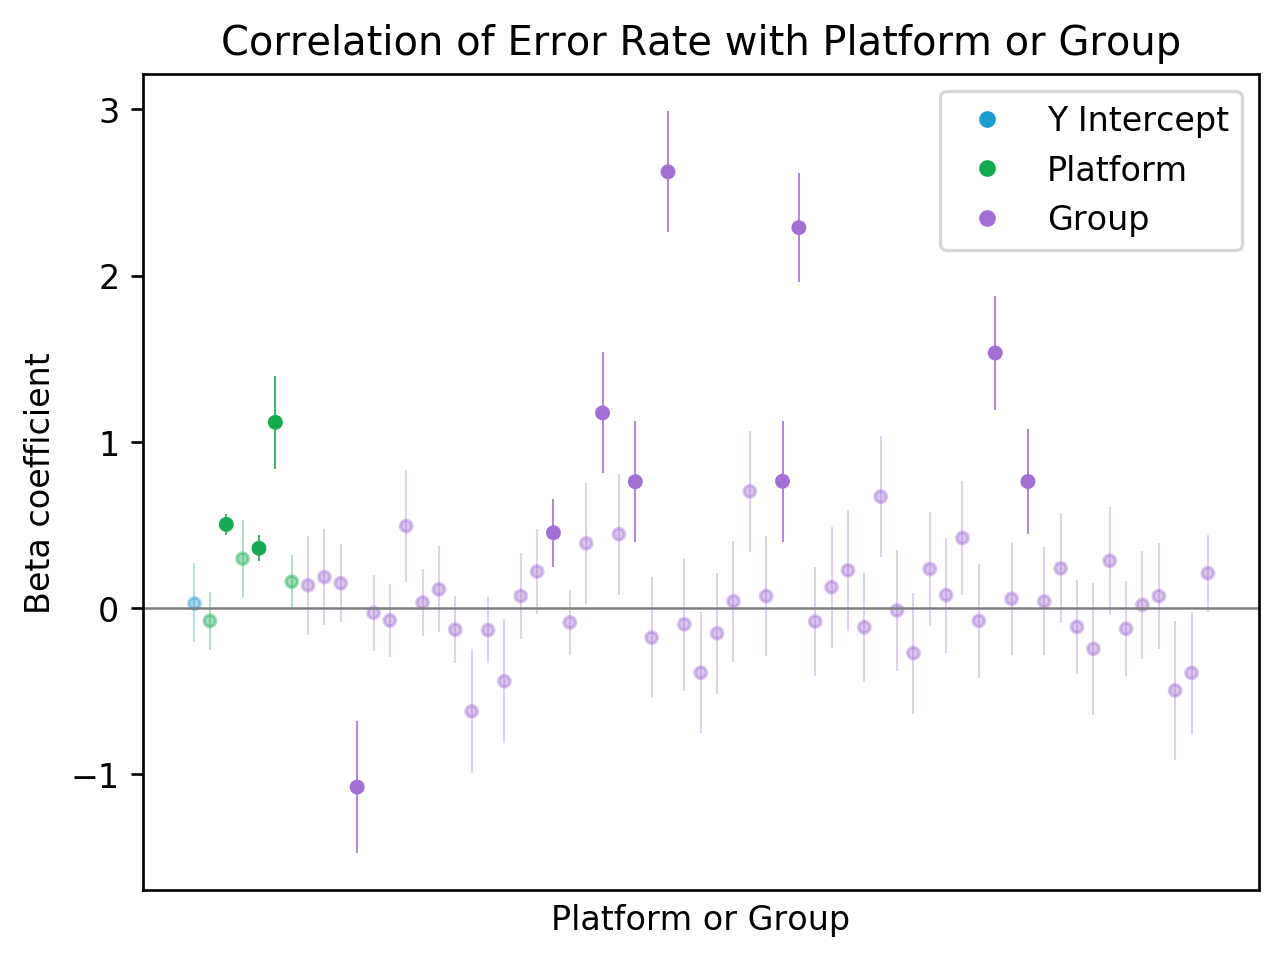

In [34]:
plot_coefs(params)

HiSeq X Ten
MiSeq
MiniSeq
NextSeq 500
NextSeq 550
NovaSeq 6000


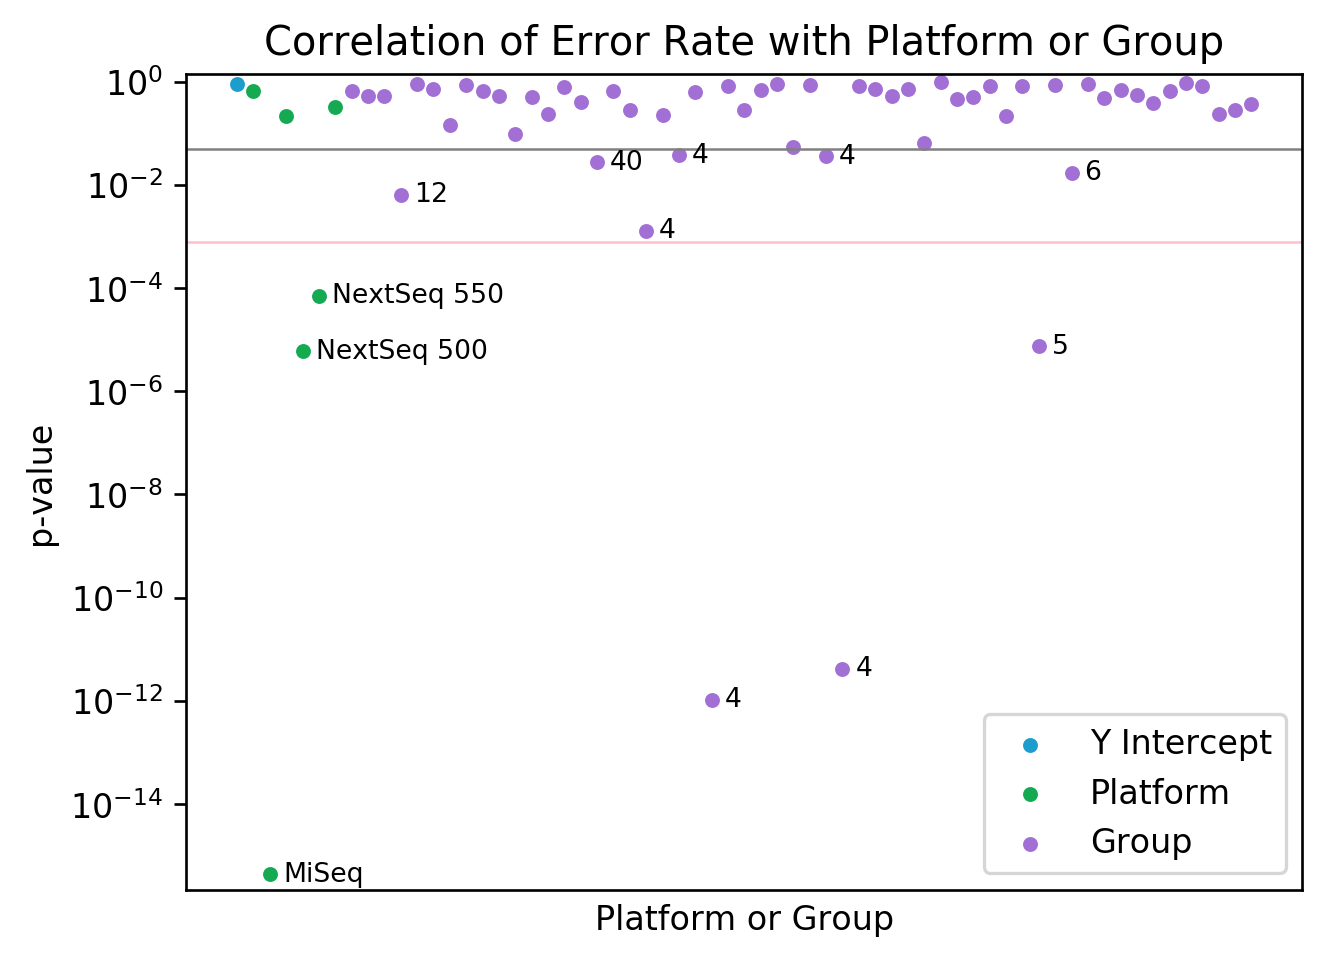

In [35]:
plot_pvals(params)